In [47]:
import numpy as np
import matplotlib.pyplot as plt

Ex = np.loadtxt("../main_files/Ex_t.dat")
f = np.loadtxt("../main_files/f.dat")
t = np.arange(Ex.shape[0])


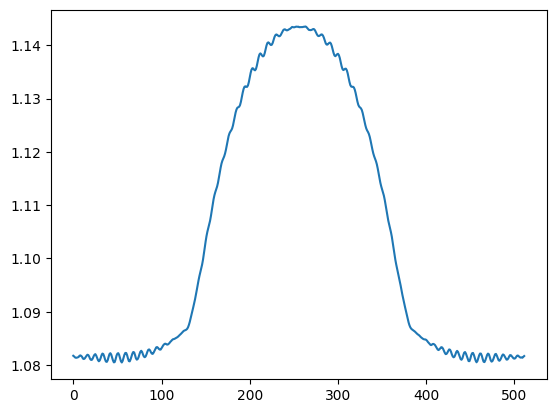

In [46]:
plt.plot(f[9000,:])

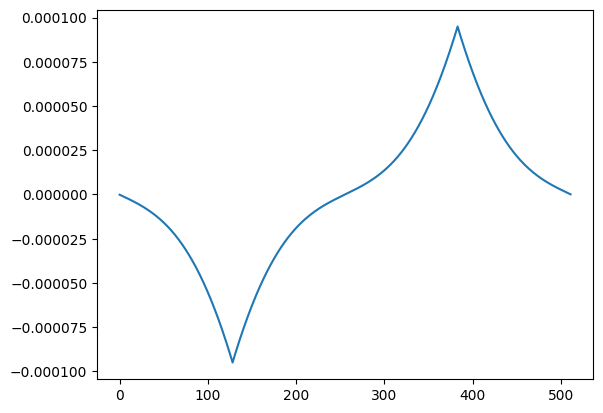

In [41]:
plt.plot(Ex[2900,:])


In [55]:
t_fit = t[10:50]
logE = np.log(Emax[10:50])

coef = np.polyfit(t_fit, logE, 1)
gamma_num = coef[0]

print("measured gamma =", gamma_num)

measured gamma = 0.03632814946244517


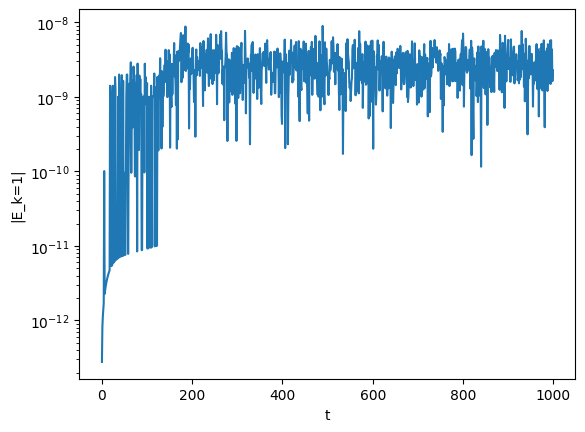

In [32]:
Exk = np.fft.fft(Ex, axis=1)
Ek1 = np.abs(Exk[:,20])

plt.semilogy(t, Ek1)
plt.xlabel("t")
plt.ylabel("|E_k=1|")
plt.show()


MovieWriter ffmpeg unavailable; using Pillow instead.


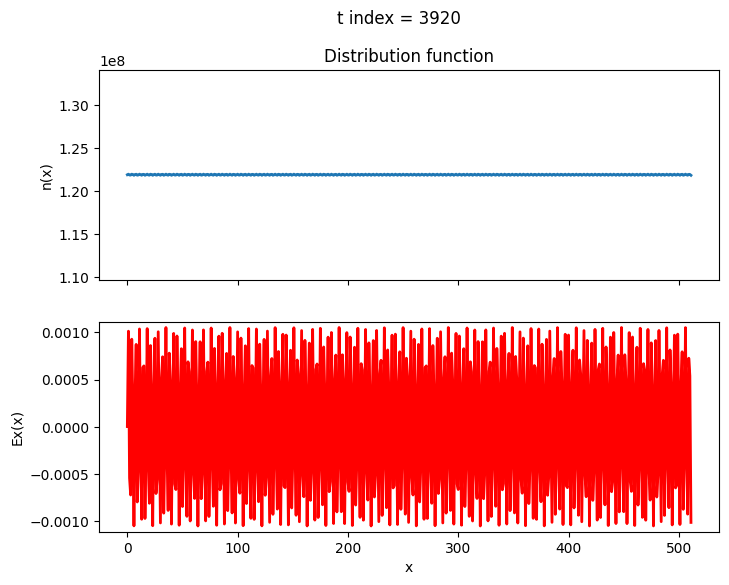

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# ======================
# データ読み込み
# ======================
Ex = np.loadtxt("../main_files/Ex_t.dat")
f  = np.loadtxt("../main_files/f.dat")

# 平均除去（強く推奨）
# Ex = Ex - Ex.mean(axis=1, keepdims=True)

Nt, Nx = Ex.shape
x = np.arange(Nx)

# ======================
# アニメーション設定
# ======================
stride   = 49      # ← 何ステップごとに1コマ使うか
nframes  = 400    # ← 作りたいコマ数
interval = 50     # ms

max_frames = Nt // stride
nframes = min(nframes, max_frames)

frames = stride * np.arange(nframes)

# ======================
# 図の初期化
# ======================
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

line_f, = axes[0].plot(x, f[frames[0]], lw=2)
axes[0].set_ylabel("n(x)")
axes[0].set_title("Distribution function")

line_E, = axes[1].plot(x, Ex[frames[0]], lw=2, color='r')
axes[1].set_ylabel("Ex(x)")
axes[1].set_xlabel("x")

# 軸固定（超重要）
axes[0].set_ylim(f.min(), f.max())
axes[1].set_ylim(Ex.min(), Ex.max())

# ======================
# 更新関数
# ======================
def update(i):
    it = frames[i]
    line_f.set_ydata(f[it])
    line_E.set_ydata(Ex[it])
    fig.suptitle(f"t index = {it}")
    return line_f, line_E

# ======================
# アニメーション生成
# ======================
ani = FuncAnimation(
    fig, update,
    frames=nframes,
    interval=interval,
    blit=True
)

ani.save("f_and_E_stride5.gif", fps=20)



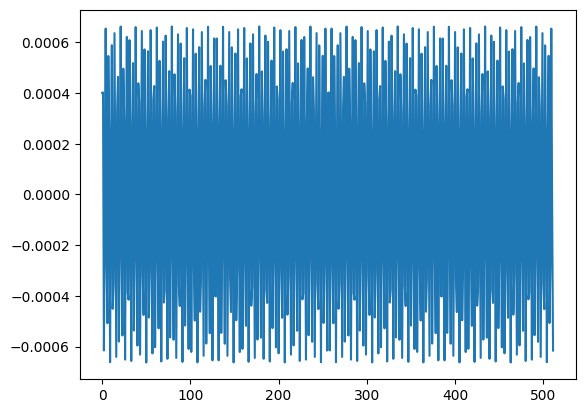

In [68]:
plt.plot(Ex[0,:])

In [ ]:
import struct
import numpy as np
import cv2
from IPython.display import display, Image, HTML
import glob
import imageio

# =============================
#   描画パラメータ
# =============================
XMIN, XMAX = 0, 20.
YMIN, YMAX = -15, 15
RES = 800  # 画像解像度

def load_frame(FNAME):
    with open(FNAME, "rb") as f:
        Nx = struct.unpack("q", f.read(8))[0]
        Ny = struct.unpack("q", f.read(8))[0]

        vx_all = np.zeros((Nx,Ny,4))
        vy_all = np.zeros((Nx,Ny,4))
        val_all = np.zeros((Nx,Ny))

        for i in range(Nx):
            for j in range(Ny):
                vx = struct.unpack("4d", f.read(32))
                vy = struct.unpack("4d", f.read(32))
                val = struct.unpack("d",  f.read(8))[0]

                vx_all[i,j] = vx
                vy_all[i,j] = vy
                val_all[i,j] = val

    return vx_all, vy_all, val_all


def world_to_img(x, y):
    ix = int((x - XMIN) / (XMAX - XMIN) * RES)
    iy = int((YMAX - y) / (YMAX - YMIN) * RES)
    return (ix, iy)


def frame_to_image(vx_all, vy_all, val_all):
    # normalize values
    vmin, vmax = val_all.min(), val_all.max()
    print("max:",vmax/0.7769748367466968)
    val_norm = (val_all - vmin) / (vmax - vmin + 1e-12)
    val_norm *= 255

    Nx, Ny = val_all.shape

    img = np.zeros((RES, RES, 3), dtype=np.uint8)

    for i in range(Nx):
        for j in range(Ny):
            pts = np.array([
                world_to_img(vx_all[i,j,k], vy_all[i,j,k])
                for k in range(4)
            ], np.int32)

            color = int(val_norm[i,j])
            cv2.fillPoly(img, [pts], (0,0,color))

    return img

# =============================
#   アニメーション作成
# =============================

files = sorted(glob.glob("../output/two_stream/*.bin"), key=lambda s: int(s.split('/')[-1].split('.')[0]))
frames = []

for i, fn in enumerate(files):
    print(f"loading {fn} ({i+1}/{len(files)})")
    vx, vy, val = load_frame(fn)
    img = frame_to_image(vx, vy, val)
    frames.append(img)

# GIF 保存
gif_path = "../output/two_stream_instability.gif"
fps = 15

imageio.mimsave(gif_path, frames, fps=fps)

print(f"GIF saved to {gif_path}")


loading ../output/two_stream/0.bin (1/4000)
max: 15763.310080158608
loading ../output/two_stream/1.bin (2/4000)
max: 15763.297773794768
loading ../output/two_stream/2.bin (3/4000)
max: 15763.237239973441
loading ../output/two_stream/3.bin (4/4000)
max: 15762.966162676355
loading ../output/two_stream/4.bin (5/4000)
max: 15762.630790748413
loading ../output/two_stream/5.bin (6/4000)
max: 15762.349585610324
loading ../output/two_stream/6.bin (7/4000)
max: 15762.311194568207
loading ../output/two_stream/7.bin (8/4000)
max: 15762.232622568621
loading ../output/two_stream/8.bin (9/4000)
max: 15762.113930459036
loading ../output/two_stream/9.bin (10/4000)
max: 15761.95509881796
loading ../output/two_stream/10.bin (11/4000)
max: 15761.756189342583
loading ../output/two_stream/11.bin (12/4000)
max: 15761.518787192135
loading ../output/two_stream/12.bin (13/4000)
max: 15761.24296825118
loading ../output/two_stream/13.bin (14/4000)
max: 15760.928428356958
loading ../output/two_stream/14.bin (15/4

KeyboardInterrupt: 

In [80]:
vx, vy, val = load_frame("../output/two_stream/7000.bin")
img = frame_to_image(vx, vy, val)

max: 14877.941364115912


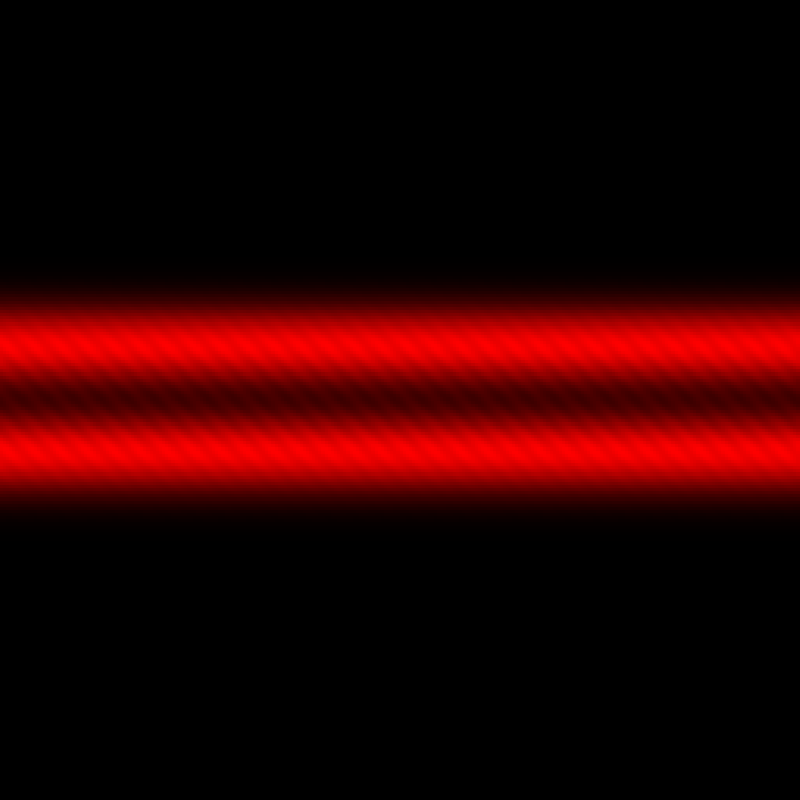

In [81]:
from IPython.display import Image, display
_, buf = cv2.imencode('.png', img)
display(Image(data=buf))